<a href="https://colab.research.google.com/github/abrodyyy/Neural_Network_Charity_Analysis/blob/main/AlphabetSoupCharity_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deliverable 3: Optimize the Model (20 points)

You will earn a perfect score for Deliverable 3 by completing all requirements below:
- The model is optimized, and the predictive accuracy is increased to over 75%, or there is working code that makes three attempts to increase model performance using the following steps:
    - Noisy variables are removed from features (2.5 pt)
    - Additional neurons are added to hidden layers (2.5 pt)
    - Additional hidden layers are added (5 pt)
    - The activation function of hidden layers or output layers is changed for optimization (5 pt)
    - The model's weights are saved every 5 epochs (2.5 pt)
    - The results are saved to an HDF5 file (2.5 pt)

#### Preprocessing

In [1]:
# Import our dependencies
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(["EIN", "NAME"], axis = 1)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [4]:
# Look at APPLICATION_TYPE value counts for binning
application_counts = application_df.APPLICATION_TYPE.value_counts()
application_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

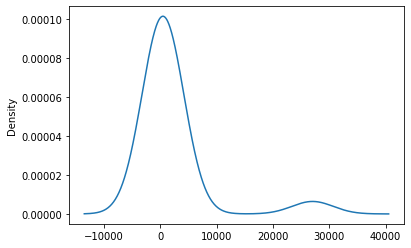

In [5]:
# Visualize the value counts of APPLICATION_TYPE
application_counts.plot.density()

In [6]:
# Determine which values to replace if counts are less than ...?
replace_application = list(application_counts[application_counts < 1000].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
Other     2266
T4        1542
T6        1216
T5        1173
T19       1065
Name: APPLICATION_TYPE, dtype: int64

In [7]:
# Look at CLASSIFICATION value counts for binning
classification_counts = application_df.CLASSIFICATION.value_counts()
classification_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

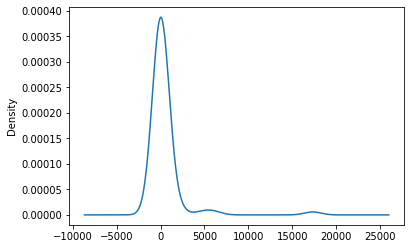

In [8]:
# Visualize the value counts of CLASSIFICATION
classification_counts.plot.density()

In [9]:
# Determine which values to replace if counts are less than ..?
replace_class = list(classification_counts[classification_counts < 1000].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [10]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [11]:
application_df[application_cat].nunique()

APPLICATION_TYPE          6
AFFILIATION               6
CLASSIFICATION            6
USE_CASE                  5
ORGANIZATION              4
INCOME_AMT                9
SPECIAL_CONSIDERATIONS    2
dtype: int64

In [12]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse = False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index = True, right_index = True)
application_df = application_df.drop(application_cat, axis = 1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# Split our preprocessed data into our features and target arrays
y = application_df.IS_SUCCESSFUL.values
X = application_df.drop("IS_SUCCESSFUL", axis = 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, stratify = y)

In [15]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#### Compile, Train, & Evanluate, & the Model 
Optimization Attempt # 1 - Additional neurons are added to hidden layers

In [16]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 160
hidden_nodes_layer2 = 80

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer1, activation = "relu", input_dim = number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, activation = "relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               6560      
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 1)                 81        
                                                                 
Total params: 19,521
Trainable params: 19,521
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile the model
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [18]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization_add_neurons/", exist_ok = True)
checkpoint_path = "checkpoints_optimization_add_neurons/weights.{epoch:02d}.hdf5"

In [19]:
# Create a callback that saves the model's weights every 5 epochs.
cp_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = "epoch",
    period = 5)

In [20]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 5s 5ms/step - loss: 0.5717 - accuracy: 0.7226
Epoch 2/100
804/804 [==============================] - 6s 8ms/step - loss: 0.5588 - accuracy: 0.7291
Epoch 3/100
804/804 [==============================] - 5s 7ms/step - loss: 0.5551 - accuracy: 0.7304
Epoch 4/100
804/804 [==============================] - 4s 6ms/step - loss: 0.5539 - accuracy: 0.7315
Epoch 5/100
800/804 [============================>.] - ETA: 0s - loss: 0.5525 - accuracy: 0.7316
Epoch 5: saving model to checkpoints_optimization_add_neurons/weights.05.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5527 - accuracy: 0.7313
Epoch 6/100
804/804 [==============================] - 3s 3ms/step - loss: 0.5515 - accuracy: 0.7317
Epoch 7/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5499 - accuracy: 0.7334
Epoch 8/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5500 - accuracy: 0.7328
Epoch 9/100
804/804 [========

In [21]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test, verbose = 2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5686 - accuracy: 0.7287 - 785ms/epoch - 3ms/step
Loss: 0.5685667395591736, Accuracy: 0.7287463545799255


#### Compile, Train, & Evanluate, & the Model 
Optimization Attempt # 2 - Additional hidden layers are added

In [22]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 160
hidden_nodes_layer2 = 80
hidden_nodes_layer3 = 40

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer1, activation = "relu", input_dim = number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, activation = "relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer3, activation = "relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 160)               6560      
                                                                 
 dense_4 (Dense)             (None, 80)                12880     
                                                                 
 dense_5 (Dense)             (None, 40)                3240      
                                                                 
 dense_6 (Dense)             (None, 1)                 41        
                                                                 
Total params: 22,721
Trainable params: 22,721
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compile the model
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [24]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization_add_layers/", exist_ok = True)
checkpoint_path = "checkpoints_optimization_add_layers/weights.{epoch:02d}.hdf5"

In [25]:
# Create a callback that saves the model's weights every 5 epochs.
cp_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = "epoch",
    period = 5)

In [26]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5684 - accuracy: 0.7222
Epoch 2/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5576 - accuracy: 0.7290
Epoch 3/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5548 - accuracy: 0.7295
Epoch 4/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5537 - accuracy: 0.7318
Epoch 5/100
787/804 [============================>.] - ETA: 0s - loss: 0.5521 - accuracy: 0.7316
Epoch 5: saving model to checkpoints_optimization_add_layers/weights.05.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5520 - accuracy: 0.7320
Epoch 6/100
804/804 [==============================] - 3s 3ms/step - loss: 0.5512 - accuracy: 0.7329
Epoch 7/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5502 - accuracy: 0.7327
Epoch 8/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5496 - accuracy: 0.7334
Epoch 9/100
804/804 [=========

In [27]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test, verbose = 2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5829 - accuracy: 0.7290 - 482ms/epoch - 2ms/step
Loss: 0.5829164385795593, Accuracy: 0.7289795875549316


#### Compile, Train, & Evanluate, & the Model

Optimization Attempt # 3 - The activation function of hidden layers changed for optimization

In [28]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer1, activation = "tanh", input_dim = number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, activation = "tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 80)                3280      
                                                                 
 dense_8 (Dense)             (None, 30)                2430      
                                                                 
 dense_9 (Dense)             (None, 1)                 31        
                                                                 
Total params: 5,741
Trainable params: 5,741
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compile the model
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [30]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization_activation_function/", exist_ok = True)
checkpoint_path = "checkpoints_optimization_activation_function/weights.{epoch:02d}.hdf5"

In [31]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5752 - accuracy: 0.7203
Epoch 2/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5603 - accuracy: 0.7280
Epoch 3/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5574 - accuracy: 0.7283
Epoch 4/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5544 - accuracy: 0.7313
Epoch 5/100
779/804 [============================>.] - ETA: 0s - loss: 0.5535 - accuracy: 0.7308
Epoch 5: saving model to checkpoints_optimization_add_layers/weights.05.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5537 - accuracy: 0.7303
Epoch 6/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5520 - accuracy: 0.7317
Epoch 7/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5513 - accuracy: 0.7311
Epoch 8/100
804/804 [==============================] - 3s 3ms/step - loss: 0.5507 - accuracy: 0.7318
Epoch 9/100
804/804 [=========

In [32]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test, verbose = 2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5604 - accuracy: 0.7297 - 595ms/epoch - 2ms/step
Loss: 0.5603558421134949, Accuracy: 0.72967928647995


#### Compile, Train, & Evanluate, & the Model

Optimization Attempt # 4 - Adding the number of epochs to the training regimen.

In [33]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer1, activation = "relu", input_dim = number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, activation = "relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 80)                3280      
                                                                 
 dense_11 (Dense)            (None, 30)                2430      
                                                                 
 dense_12 (Dense)            (None, 1)                 31        
                                                                 
Total params: 5,741
Trainable params: 5,741
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Compile the model
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [35]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization_add_epochs/", exist_ok = True)
checkpoint_path = "checkpoints_optimization_add_epochs/weights.{epoch:02d}.hdf5"

In [36]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=200, callbacks=[cp_callback])

Epoch 1/200
804/804 [==============================] - 4s 3ms/step - loss: 0.5707 - accuracy: 0.7200
Epoch 2/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5566 - accuracy: 0.7297
Epoch 3/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5543 - accuracy: 0.7300
Epoch 4/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5523 - accuracy: 0.7309
Epoch 5/200
803/804 [============================>.] - ETA: 0s - loss: 0.5517 - accuracy: 0.7303
Epoch 5: saving model to checkpoints_optimization_add_layers/weights.05.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5517 - accuracy: 0.7303
Epoch 6/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5508 - accuracy: 0.7321
Epoch 7/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5497 - accuracy: 0.7328
Epoch 8/200
804/804 [==============================] - 3s 3ms/step - loss: 0.5492 - accuracy: 0.7323
Epoch 9/200
804/804 [=========

In [37]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test, verbose = 2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5669 - accuracy: 0.7292 - 970ms/epoch - 4ms/step
Loss: 0.56687992811203, Accuracy: 0.7292128205299377


#### Compile, Train, & Evanluate, & the Model

Optimization Attempt # 5 - Reducing the number of epochs to the training regimen.

In [38]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer1, input_dim = number_input_features, activation = "relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, activation = "relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 80)                3280      
                                                                 
 dense_14 (Dense)            (None, 30)                2430      
                                                                 
 dense_15 (Dense)            (None, 1)                 31        
                                                                 
Total params: 5,741
Trainable params: 5,741
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Compile the model
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [40]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization_reduce_epochs/", exist_ok = True)
checkpoint_path = "checkpoints_optimization_reduce_epochs/weights.{epoch:02d}.hdf5"

In [41]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50, callbacks=[cp_callback])

Epoch 1/50
804/804 [==============================] - 4s 3ms/step - loss: 0.5756 - accuracy: 0.7191
Epoch 2/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5600 - accuracy: 0.7283
Epoch 3/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5563 - accuracy: 0.7297
Epoch 4/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5553 - accuracy: 0.7312
Epoch 5/50
795/804 [============================>.] - ETA: 0s - loss: 0.5531 - accuracy: 0.7307
Epoch 5: saving model to checkpoints_optimization_add_layers/weights.05.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5530 - accuracy: 0.7305
Epoch 6/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5531 - accuracy: 0.7310
Epoch 7/50
804/804 [==============================] - 2s 3ms/step - loss: 0.5510 - accuracy: 0.7308
Epoch 8/50
804/804 [==============================] - 3s 4ms/step - loss: 0.5518 - accuracy: 0.7323
Epoch 9/50
804/804 [==================

In [42]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test, verbose = 2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5577 - accuracy: 0.7303 - 465ms/epoch - 2ms/step
Loss: 0.5577293634414673, Accuracy: 0.7302623987197876


#### Compile, Train, & Evanluate, & the Model

Optimization Attempt # 6 - Experimenting with KerasTuner

In [52]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
import keras_tuner as kt

In [71]:
# Write a function that creates and returns a Keras model. 
# Use the hp argument to define the hyperparameters during model creation.
def build_model(hp):
    nn = tf.keras.models.Sequential()
    
    # Determine which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])
    nn.add(tf.keras.layers.Dense(units = hp.Int('first_units',
        min_value = 1,
        max_value = 30,
        step = 5), activation=activation, input_dim = number_input_features))
    
    # Determine optimal number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn.add(tf.keras.layers.Dense(units = hp.Int('units_' + str(i),
            min_value = 1,
            max_value = 30,
            step = 5),
            activation = activation))
    
    nn.add(tf.keras.layers.Dense(units = 1 , activation = "sigmoid"))

    # Compile the model
    nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    
    return nn


In [72]:
# Initialize a tuner
tuner = kt.Hyperband(
    build_model,
    objective = "val_accuracy",
    max_epochs = 20,
    hyperband_iterations = 2)

In [57]:
# Search for Best Model
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 01m 09s]
val_accuracy: 0.7304956316947937

Best val_accuracy So Far: 0.7322449088096619
Total elapsed time: 00h 19m 33s


In [73]:
# Search for Best Model
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

In [74]:
# Get top 3 model hyperparameters
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'relu', 'first_units': 26, 'num_layers': 1, 'units_0': 16, 'units_1': 11, 'units_2': 6, 'units_3': 26, 'units_4': 1, 'tuner/epochs': 25, 'tuner/initial_epoch': 9, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0042'}
{'activation': 'tanh', 'first_units': 21, 'num_layers': 2, 'units_0': 21, 'units_1': 26, 'units_2': 11, 'units_3': 26, 'units_4': 16, 'tuner/epochs': 25, 'tuner/initial_epoch': 9, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0018'}
{'activation': 'relu', 'first_units': 26, 'num_layers': 1, 'units_0': 16, 'units_1': 11, 'units_2': 6, 'units_3': 26, 'units_4': 1, 'tuner/epochs': 9, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0041'}


In [75]:
# Get the best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'first_units': 26,
 'num_layers': 1,
 'units_0': 16,
 'units_1': 11,
 'units_2': 6,
 'units_3': 26,
 'units_4': 1,
 'tuner/epochs': 25,
 'tuner/initial_epoch': 9,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0042'}

In [77]:
tuner.results_summary(5)

Results summary
Results in ./untitled_project
Showing 5 best trials
Trial summary
Hyperparameters:
activation: relu
first_units: 26
num_layers: 1
units_0: 16
units_1: 11
units_2: 6
units_3: 26
units_4: 1
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0042
Score: 0.7322449088096619
Trial summary
Hyperparameters:
activation: tanh
first_units: 21
num_layers: 2
units_0: 21
units_1: 26
units_2: 11
units_3: 26
units_4: 16
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 0.7318950295448303
Trial summary
Hyperparameters:
activation: relu
first_units: 26
num_layers: 1
units_0: 16
units_1: 11
units_2: 6
units_3: 26
units_4: 1
tuner/epochs: 9
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0041
Score: 0.7317784428596497
Trial summary
Hyperparameters:
activation: tanh
first_units: 16
num_layers: 3
units_0: 6
units_1: 1
units_2: 21
units_3: 1
units_4: 1
tuner/epochs: 25
tuner/initial_e